## Lab4

## Preparation

In [1]:
import nltk
from nltk.corpus import cmudict
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, RegexpTagger, UnigramTagger
import re
import lxml
import lxml.etree
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
from collections import defaultdict
from zipfile import ZipFile
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier 
from lightgbm.sklearn import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np

nltk.download("cmudict")
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package cmudict to /Users/eun-
[nltk_data]     youngchristinapark/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/eun-
[nltk_data]     youngchristinapark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/eun-
[nltk_data]     youngchristinapark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/eun-youngchristinapark/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /Users/eun-
[nltk_data]     youngchristinapark/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
def read_txt_file(input_file, delimiter = '\n', mode = 0):
    ''' This function reads a textfile and creates a list from the content.
    Argument:
    --------
    input_file: location of the text file.
    delimiter: delimiter used to create the list
    mode: 0 to get the content of the file as a list.
          1 to get the number of items in the file broken by the delimiter

    Returns:
    --------
    if mode == 0, returns the content of the file as a list delimited by the delimiter.
       mode == 1, returns the length of the file delimited by the delimiter
    '''
    
    f = open(input_file)
    file_content = f.read()
    f.close()
    
    if mode == 1:
        return len(file_content.split(delimiter))
    return file_content.split(delimiter)

In [3]:
assert read_txt_file('data/testfile.txt') == ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
assert read_txt_file('data/testfile.txt',mode = 1) == 7
print('success!')

success!


In [5]:
############################################ Global Variables ##################################################
zip_file = './data/lang-8.zip'
data_directory = './data/'
lang_8_directory = 'lang-8/'
train_txt = 'train.txt'
test_txt = 'test.txt'
dev_txt = 'dev.txt'

european_cities = 'data/european_cities.txt'
asian_cities = 'data/asian_cities.txt'
european_food = 'data/european_food.txt'
asian_food = 'data/asian_food.txt'
european_culture = 'data/european_culture.txt'
asian_culture = 'data/asian_culture.txt'
european_language_set = {'spanish','french'}
special_non_alpha_set = {'~', '-', ';', '^', '*', '<', '>', '+', '_'}

European = set(read_txt_file(european_cities)) | set(read_txt_file(european_food)) | set(read_txt_file(european_culture))
Asian = set(read_txt_file(asian_cities)) | set(read_txt_file(asian_food)) | set(read_txt_file(asian_culture))

vowels = {"a","e","i","o","u","y"}
p_dict = cmudict.dict() 

lemmatizer= WordNetLemmatizer()

#### Added on Dec 11 
irreg_pp_list = read_txt_file('data/irreg_pp.txt')
regex_perfect_as = '^((have|has|had)\s(not\s)?|haven\'t\s|hasn\'t\s|hadn\'t\s)([a-z]+[^e](ed|en)'
for w in irreg_pp_list:
    regex_perfect_as = regex_perfect_as + '|' + w
regex_perfect_as = regex_perfect_as + ')$'

#### For reading files ########
READ_FROM_DIR = 0
READ_FROM_ZIP = 1
READ_CONTENT = 0
READ_NUM = 1
MODE_TRAIN = 0
MODE_VALID = 1 
DECISION_TREE = 0
RANDOM_FOREST = 1
LGBM = 2
CATBOOST = 3

## Part 1: Construct HTML files and raw data

In [6]:
def get_html_file(text_file_name):
    ''' This function sets up the reading of the input file.
    This function assumes that the html files are stored in the ./data/lang-8.zip file.

    Argument:
    ---------
    text_file_name: indicates the text file which contains the names of html files.

    Returns:
    --------
    the filename of the html file
    '''
    
    f = open(data_directory + text_file_name, "r")
    contents = f.read()
    f.close()
    file_list = contents.split('\n')
    
    for filename in file_list:
        yield filename
        
def get_raw_data(g, mode = READ_FROM_ZIP):
    ''' This function returns the native language and the raw text of the html file.
    This function assumes that the html files are stored in the ./data/lang-8/ directory.

    Argument:
    ---------
    None

    Returns:
    --------
    the filename of the html file, the native language of the writer and the raw text of the html file
    '''
    
    filename = next(g)
    file_location = lang_8_directory + filename
    
    if mode == 1:
        my_zip = ZipFile(zip_file)
        filepg = BeautifulSoup(my_zip.open(file_location), 'lxml')
    else:
        file_location = data_directory + file_location
        filepg = BeautifulSoup(open(file_location), 'lxml')

    for div in filepg.find_all('div'):
        if 'id' in div.attrs and div['id'] == 'body_show_ori':
            raw_text = div.get_text().replace('\n',' ')
            break
    
    
    for node in filepg.find_all('li'):
        if 'title' in node.attrs and node['title'] == 'Native language':
            native_language = node.get_text()
            break
    
    return (filename, native_language, raw_text)

In [7]:
g = get_html_file(train_txt)
filename, native_language, raw_text = get_raw_data(g)
print(filename)
print(native_language)
print(raw_text)

193455.html
Russian
 Mei name is Tatjana/ I from Russia. I live in Uljanovsk. 


## Part 2: Feature Extraction

The features that our team have created and tests for each feature extraction functions are as follows. A function for constructing a list of dictionaries for features are at the bottom of this section.

### 2.1 Feature extraction functions

In [8]:
def get_lex_density(pos_list):
    """Calculate lexical density of a text by total number of open class
    divided by the number of words in the text

    Parameters
    ----------
    pos_list : list
        a list of tuples of (word, pos)

    Returns
    -------
    float
        lexical density of a given text
    """
    
    open_class_pos = {"NOUN", "VERB", "ADJ", "ADV", "PROPN"}
    open_class_total = 0

    for word, pos in pos_list:
        if pos in open_class_pos:
            open_class_total += 1
    
    return open_class_total / len(pos_list)

In [9]:
# this function is for tests

def get_pos_tag(text):
    '''Get a pos-tagged list of a given text'''
    return pos_tag(word_tokenize(text), tagset="universal")

In [10]:
text1 = "I have a cat."
text2 = "I have to get a cat that has beautiful fur."

assert get_lex_density(get_pos_tag(text1)) == 0.4
assert get_lex_density(get_pos_tag(text2)) > get_lex_density(get_pos_tag(text1))
print("success!")

success!


In [11]:
def get_adj_ratio(pos_list):
    """Calculate a ratio of the number of adjectives
    to the number of words in a given text

    Parameters
    ----------
    pos_list : list
        a list of tuples of (word, pos)

    Returns
    -------
    float
        a ratio of adjectives to the number of words in the text
    """
    
    adj_freq = 0
    
    for word, pos in pos_list:
        
        if pos == "ADJ":
            adj_freq += 1
    
    return adj_freq / len(pos_list)

In [12]:
text1 = "I have a beautiful cat"
text2 = "I have a pen"

assert get_adj_ratio(get_pos_tag(text1)) == 0.2
assert get_adj_ratio(get_pos_tag(text2)) == 0
print("success!")

success!


In [13]:
def get_ratio_det_noun(pos_list):
    """Calculate a ratio of combinations of determinant-noun to 
    the number of words in a give text. For simplicity, this considers
    only two cases: "(PRON|DET) NOUN" or "(PRON|DET) ADJ NOUN".

    Parameters
    ----------
    pos_list : list
        a list of tuples of (word, pos)

    Returns
    -------
    float
        a ratio of combinations of determinant-noun to the number of words in the text
    """
    total_det_noun = 0
    det_set = {"PRON", "DET"}
    i = 0
    for word, pos in pos_list:
        if pos == "NOUN" and i > 1 and pos_list[i-1][1] in det_set: # for the case such as "a dog"
            total_det_noun += 1
        elif pos == "NOUN" and i > 2 and pos_list[i-2][1] in det_set: # for the case such as "a good dog"
            total_det_noun += 1
            
        i += 1
    
    return total_det_noun / len(pos_list)

In [14]:
text1 = "He has a dog"
text2 = "He has dog"
text3 = "He has a good dog"

assert get_ratio_det_noun(get_pos_tag(text1)) > get_ratio_det_noun(get_pos_tag(text2))
assert get_ratio_det_noun(get_pos_tag(text3)) == 1/5
print("success!")

success!


In [15]:
def is_adj_noun(pos_list):
    """Check if an adjective is prior to a noun in a given text

    Parameters
    ----------
    pos_list : list
        a list of tuples of (word, pos)

    Returns
    -------
    bool
        return true if an adjective is prior to a noun
        return false if otherwise
    """
    
    i = 0
    for word, pos in pos_list:
        if pos == "ADJ" and i < len(pos_list) -1:
            if pos_list[i+1][1] == "NOUN":
                return True
        i += 1
        
    return False

In [16]:
text1 = "Hello I got a pencil red"
text2 = "Hello I got a red pencil"
text3 = "This is a cool lab"

assert not is_adj_noun(get_pos_tag(text1))
assert is_adj_noun(get_pos_tag(text2))
assert is_adj_noun(get_pos_tag(text3))
print("success!")

success!


In [17]:
def get_ratio_special_non_alpha(text):
    """Calculate a ratio of the number of special non alphanumeric characters
    over the length of a given text. "Special non alphanumeric characters" are 
    a set of characters that are often used to create text emoticons in many Eastern Asian culture.

    Parameters
    ----------
    text : str
        a string of a text

    Returns
    -------
    float
        a ratio of the number of special non alphanumeric characters
        over the length of a given text
    """
    count_non_alpha = 0
    for char in text:
        if char in special_non_alpha_set:
            count_non_alpha += 1
    
    return count_non_alpha / len(text)

In [18]:
text1 = "Hi~~~ The weather is so nice ^^ I want to have some coffee +_+ Yesterday was raining all day T_T"
text2 = "Hi the weather is so nice, I want to have some coffee! Yesterday was raining all day."

assert get_ratio_special_non_alpha(text1) > get_ratio_special_non_alpha(text2)
assert not get_ratio_special_non_alpha(text2)
print("success!")

success!


In [20]:
#SYLLABLE DIV LENGTH OF SENTENCE
def syl_div_length(text):
    '''use CMU dict (p_dict) to count the number of syllables in word,
    default to number of vowels, then divides by the number of periods in the text
    Input
    -----
        text: str
    Returns
    ------- 
        Int: number indicating the result
    '''
    length_of_sentence = len(text)
    text = text.lower()
    # text_list = text.split(" ")
    #or I could count number of periods instead, as the number of sentences?
    syllable_count = 0
    if text in p_dict:
        for phone in p_dict[text][0]:
            if phone[-1].isdigit():
                syllable_count += 1
    else:
        for letter in text:
            if letter in vowels:
                syllable_count += 1
    return (syllable_count / length_of_sentence)
# syl_div_length("hello I am Bob")

assert(syl_div_length("hello I am Bob") == 5/len("hello I am Bob"))
assert(syl_div_length("hello I am Bob") != 20/len("hello I am Bob"))
assert(syl_div_length("hi there I am Bob") == 6/len("hi there I am Bob"))
assert(syl_div_length("Bob") == 1/len("Bob"))

In [21]:
def sentence_completeness_boolean_revised(pos_list):
    '''Checking if there are equal or more nouns to verbs in the input text
    Input
    -----
    pos_list : list
        a list of tuples of (word, pos)
    Returns
    ------- 
        Boolean: True of False
    '''
    verb_count = 0
    noun_count = 0 
    for word, pos in pos_list:
        if pos == "NOUN" or pos == "PRON":
            noun_count += 1
        if pos == "VERB":
            verb_count += 1
    if noun_count > 0 and verb_count > 0 and noun_count / verb_count > 1:
        return True
    else: 
        return False

assert(sentence_completeness_boolean_revised(get_pos_tag("hello I am Bob")) == True)
assert(sentence_completeness_boolean_revised(get_pos_tag("Bob Bob")) != True)
assert(sentence_completeness_boolean_revised(get_pos_tag("He ate the")) != True)
assert(sentence_completeness_boolean_revised(get_pos_tag("I")) != True)
assert(sentence_completeness_boolean_revised(get_pos_tag("I ran sat outside")) == True)

In [22]:
#NUM OF NOUNS&PRON / VERBS
def sentence_completeness_ratio(pos_list):
    '''Dividing the number of nouns/pronouns by verb. Starting at 1 to avoid division errors.
    The scaling won't affect our decision trees as DTs are not affected by scaling.
    Input
    -----
    pos_list : list
        a list of tuples of (word, pos)
    Returns
    ------- 
        Int: number dividing nouns/verbs
    '''
    verb_count = 1
    noun_count = 1 
    #starting at 1 for both, because of division of zero errors 
    for word, pos in pos_list:
        if pos == "NOUN":
            noun_count += 1
        if pos == "PRON":
            noun_count +=1
        elif pos == "VERB":
            verb_count += 1
    return noun_count / verb_count

assert(sentence_completeness_ratio(get_pos_tag("I am Bob")) == 3/2)
assert(sentence_completeness_ratio(get_pos_tag("I am Bob the plant")) == 3/2)
assert(sentence_completeness_ratio(get_pos_tag("I ate the food")) == 3/2)
assert(sentence_completeness_ratio(get_pos_tag("I")) == 2/1)

In [23]:
def lemm_text_matching(text):
    '''Lemmatize input string to see whether the input sentence is in
    lemmatized form
    Input
    -----
        text: str
    Returns
    ------- 
        Boolean: True if it completely matches the root forms of each word
    '''
    word_list = nltk.word_tokenize(text)
    # print(word_list)
    lemmas = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    # print(lemmas)
    # print(text)
    # #' '.join
    if lemmas.lower() == text.lower():
        return True
    else:
        return False
# lemm_text_matching("I like using the reds pencils")
assert(lemm_text_matching("I like using the reds pencils") == False)
assert(lemm_text_matching("I like using the red pencils") == False)
assert(lemm_text_matching("I like using the red pencil") == True)
assert(lemm_text_matching("I likeds thes red pencil") == True)
assert(lemm_text_matching("He has eating the food") == False)

In [25]:
def type_token_ratio(text):
    '''calculate type-token ratio from the raw text 
    Argument:
    --------
    raw_text: a string of text
    '''
    words = word_tokenize(text)
    num_words = len(words)

    types = set([word.lower() for word in words[:num_words]])

    return len(types)/num_words


text2 = "Hello Hello Hello"
text3 = "This is a cool lab"

assert type_token_ratio(text2) == 1/3
assert type_token_ratio(text3) == 1.0 
print('success!')

success!


In [26]:
def get_freq_art(raw_text, mode = 0):
    '''
    This function returns the frequency of the articles in the given text.
    Argument:
    --------
    raw_text: a string of text
    mode: an optional parameter. If set to 1, it reutnrs the frequency of the articles in the text as well as the list of articles in the text.
          If set to 0, it returns the frequency of the articles in the text only. 
          
    Returns:
    --------
    If mode is set to 1, it reutnrs the frequency of the articles in the text as well as the list of articles in the text.
    If mode is set to 0, it returns the frequency of the articles in the text only. 
    '''
    token_text = word_tokenize(raw_text) 
    regex = r'^(a|an|des|du|de l\'|de la|el|l\'|la|le|las|les|los|un|una|unas|une|unos|the)$'

    if len(token_text) == 0:
        return
    
    num_articles = 0
    list_articles = []
    for t in token_text:
        match = re.match(regex, t.lower())
        if match:
            num_articles +=1
            list_articles.append(match.group())
    
    if mode == 1:
        return(num_articles/len(token_text), list_articles)
    return (num_articles/len(token_text))

In [27]:
test_text = 'In it days of pascuas, we are celebrated : The December 21 that is the day of the Spirit of the Christmas, where the angel Gabriel celebrates the arrival to Maria. We celebrate it with it has dinner from friends and family, in this 21 desires are asked for the prime year and one writes a leaf bad what of the year that then burns to eliminate it of our lives.December 24 is the day that god celebrates the Christmas or the birth in of the child; in the mangers the figure of the child is placed after 12 of the night as sign of birth. December 28 is the Day of the Santos Inocentes, where jokes all are played, this date according to the Catholic Church is one pagan - religious celebrates since masses and festivals realize in commemoration of millions of children salted and dried 2009 years ago with the birth of the Messiah.December 31 is the typical festivity with the fireworks, the count is realized before the new year. In we have the tradition of 12 grapes of the time, this tradition it is necessary to eat 12 grapes before 12 a.m. and for every grape that commas you can a desire, that is to say, that have 12 desires in whole.My favorite taboo 31 with the growing up that if wearing yellow underwear have prosperity in the year, as is if after the 12 salts with a suitcase in the street and greet neighbors and give them the new year have many trips that year, and also the belief of thinking that if you have dollars and the passport in the year you will have prosperity in the year.'
test_word = word_tokenize(test_text)
assert get_freq_art(test_text) == (test_word.count('a') + test_word.count('A') + test_word.count('the') + test_word.count('The'))/len(test_word)
assert get_freq_art('a') == 1
assert get_freq_art('오늘은 목요일이다.') == 0
assert get_freq_art('Today is Thursday.') == 0
assert get_freq_art('Magic mirror on the wall, who is the fairest one of all?') == 1/7
print('success!')

success!


In [28]:
def get_perfect_aspects(raw_text, mode = 0):
    '''
    This function returns the frequency of the articles in the given text.
    Argument:
    --------
    raw_text: a string of text
    mode: an optional parameter. If set to 1, it reutnrs the frequency of the articles in the text as well as the list of articles in the text.
          If set to 0, it returns the frequency of the articles in the text only. 
          
    Returns:
    --------
    If mode is set to 1, it reutnrs the frequency of the articles in the text as well as the list of articles in the text.
    If mode is set to 0, it returns the frequency of the articles in the text only. 
    '''
    
    token_text = raw_text.split(' ')
    if len(token_text) == 0:
        return 0
    
    num_perfect_aspects = 0
    list_perfect = []
    for i in range(len(token_text)-2):
        match2 = re.search(regex_perfect_as, token_text[i].lower() + ' ' + token_text[i+1].lower())
        match3 = re.search(regex_perfect_as, token_text[i].lower() + ' ' + token_text[i+1].lower() + ' ' + token_text[i+2].lower())
        if match2 or match3:
            num_perfect_aspects +=1
            list_perfect.append(match2.group() if match2 else match3.group())
    
    if mode == 1:
        return(num_perfect_aspects/len(token_text), list_perfect)
    return (num_perfect_aspects/len(token_text))

In [29]:
assert get_perfect_aspects('I have not eaten lunch. I have eaten breakfast.') == 2/9
assert get_perfect_aspects('I am going to eat lunch later.') == 0
assert get_perfect_aspects('We haven\'t finished the lab yet.') == 1/6
assert get_perfect_aspects('You have been there.') == 1/4
print('success!')

success!


In [30]:
def european_occurrences(raw_text):
    '''
    This function returns a value which indicates whether the text contains a European location or an Asian location.
    Argument:
    ---------
    raw text: a string
    
    Returns:
    --------- 
    0 if neither Asian or European location is mentioned.
    1 if Asian location is mentioned.
    2 if European location is mentioned.
    3 if both Asian and European locations are mentioned.
    '''

    txt_set = set(word_tokenize(raw_text.lower()))
    asian_occ = len(txt_set & Asian)
    european_occ = len(txt_set & European)
    
    return((asian_occ > 0 ) + 2*(european_occ > 0))


In [31]:
assert european_occurrences('I live in Canada.') == 0
assert european_occurrences('I live in Beijing.') == 1
assert european_occurrences('I live in Africa.') == 0
assert european_occurrences('I live in Congo.') == 2
assert european_occurrences('I have lived in Argentina and Korea.') == 3

assert european_occurrences('I eat kimchi.') == 1
assert european_occurrences('I eat dumpling.') == 1
assert european_occurrences('I eat sushi.') == 1
assert european_occurrences('I eat nachos.') == 2
assert european_occurrences('I eat bread.') == 0
assert european_occurrences('I eat dumpling and nachos.') == 3

assert european_occurrences('I study philosophy.') == 0
assert european_occurrences('I study Confucius.') == 1
assert european_occurrences('I am a Roman Catholic.') == 2
assert european_occurrences('I am a Roman Catholic and study Confucius') == 3
print('success!')

success!


In [32]:
####################################################################################################################
# Aknowledgement: This code is adopted directly from COLX 521 Lab 2. 
####################################################################################################################

def get_syllables(word):
    word = word.lower()
    '''use CMU dict (p_dict) to count the number of syllables in word, default to number of vowels
    Argument: 
    --------- 
    word: a string
    
    Returns:
    -------------
    count of syllables
    
    '''
    syllable_count = 0
    p_dict[word] = p_dict.get(word, '')
    if p_dict[word] == '':
        syllable_count = word.count('a') + word.count('e') + word.count('i')+ word.count('o')+ word.count('u')+ word.count('y')
    else:
        for ph in p_dict[word][0]:
            if ph[-1].isdigit():
                syllable_count += 1
    return syllable_count


####################################################################################################################
# Aknowledgement: This code is adopted directly from COLX 521 Lab 2. 
####################################################################################################################

def get_reading_ease(raw_text):
    '''calculate the Flesh reading ease for a single sentence consisting of a list of words (strings)
    Argument:
    ---------
    raw_text: a string
    
    Returns:
    ---------
    Flesh reading ease defined as in Lab 2
    '''
    # your code here
    total_words = 0
    total_syllables = 0

    sentence = word_tokenize(raw_text)
    for w in sentence:
        if w.isalpha():
            total_words += 1
            total_syllables += get_syllables(w)
    
    reading_ease = 0 if total_words == 0 else 206.835 - 1.015 * total_words - 84.6 * (total_syllables / total_words)
    return reading_ease

In [33]:
text_string1 = ' '.join(["I", "am", "done", ",","man"])
text_string2 = ' '.join(["Felicitations", "for", "achieving", "a", "thoroughly", "excellent", "resolution", "to", "an", "altogether", "indombidable", "conundrum", "of", "humongous", "proportions", "."])
text_string3 = '?'

assert 100 < get_reading_ease(text_string1) < 140
assert -60 < get_reading_ease(text_string2) <-20
assert get_reading_ease(text_string3) == 0
print('success!')

success!


In [34]:
def native_lang_class(lang):
    ''' This function returns 0 if the given language is Spanish or French.
                              1 otherwise. 
    Argument:
    --------
    lang: a string

    Returns:
    --------
    0 if lang is Spanish or French.
    1 otherwise. 
    '''
    if (lang.lower() in european_language_set):
        return 0
    return 1

In [35]:
assert native_lang_class('Spanish') == 0
assert native_lang_class('French') == 0
assert native_lang_class('Mandarin Chinese') == 1
assert native_lang_class('Korean') == 1
assert native_lang_class('Japanese') == 1
print('success!')

success!


### 2.2 Constructing feature dictionaries and datasets

In [36]:
def get_feature_dict(raw_text):
    ''' This function extracts features. 
    Argument:
    --------
    raw_text: a string

    Returns:
    --------
    dictionary of features 
    '''
    feature_dict = {}
    pos_list = pos_tag(word_tokenize(raw_text), tagset="universal")
    feature_dict['lex_density'] = get_lex_density(pos_list)
    feature_dict['adj_ratio'] = get_adj_ratio(pos_list)
    feature_dict['det_noun_ratio'] = get_ratio_det_noun(pos_list)
    feature_dict['adj_noun_boolean'] = int(is_adj_noun(pos_list))
    feature_dict['non_alpha_ratio'] = get_ratio_special_non_alpha(raw_text)
    feature_dict['syl_div_length'] = syl_div_length(raw_text)
    feature_dict['sent_cmp_bool'] = int(sentence_completeness_boolean_revised(pos_list))
    feature_dict['sent_cmp_ratio'] = sentence_completeness_ratio(pos_list)
    feature_dict['lemma_txt_match'] = int(lemm_text_matching(raw_text))
    feature_dict['type_token_ratio'] = type_token_ratio(raw_text)
    feature_dict['art_freq'] = get_freq_art(raw_text)
    feature_dict['perfect_aspects'] = get_perfect_aspects(raw_text)
    feature_dict['euro_asia_occ'] = european_occurrences(raw_text)
    feature_dict['reading_ease'] = get_reading_ease(raw_text)
    
    return feature_dict

In [37]:
def construct_datasets(dataset_ind_file, mode = READ_FROM_ZIP):
    ''' This function constructs X_train and y_train . 

    Argument:
    --------
    dataset_ind_file: the location of the file which contains the data set. 
    mode 0 if reading from zip file, 1 if reading from files in directory 

    Returns:
    --------
    X_train (named as feature_collection),
    filename_list (index),
    target (y_train): 
        0 if Spanish or French 1 otherwise
    '''
    
    num_files = read_txt_file(data_directory + dataset_ind_file, mode = READ_NUM)
    #breakpoint()
    g = get_html_file(dataset_ind_file)
    
    feature_collection = []
    filename_list = []
    target = []
    for g_count in range(num_files):
        filename, native_lang, raw_text = get_raw_data(g, mode)
        #print(g_count)
        if native_lang.lower() != 'russian':
            feature_collection.append(get_feature_dict(raw_text))
            filename_list.append(filename)
            target.append(native_lang_class(native_lang))

    
    return feature_collection, filename_list, target  

In [38]:
feature_dicts_t, filename_list_t, y_train = construct_datasets(train_txt)

In [39]:
feature_dicts_v, filename_list_v, y_valid = construct_datasets(dev_txt)

## Part 3: Classification

### 3.1 Vectorization (training and dev sets)

In [40]:
def vectorize(feature_dicts_train, feature_dicts_valid):
    '''vectorize given lists of dictionaries'''
    vectorizer = DictVectorizer()
    X_train = vectorizer.fit_transform(feature_dicts_train)
    X_valid = vectorizer.transform(feature_dicts_valid)
    
    return X_train, X_valid

In [41]:
X_train, X_valid = vectorize(feature_dicts_t, feature_dicts_v)

### 3.2 Preliminary accuracy score

In [42]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)
print("Preliminary accuracy score on dev_set: ", accuracy_score(y_valid, tree.predict(X_valid)))

Preliminary accuracy score on dev_set:  0.7195121951219512


### 3.3 Ablation

In [43]:
def feature_contributions(classifier, X_train, y_train, X = X_train, y = y_train, mode = 0):
    ''' This function performs ablation. 
    Arguments:
    ---------
    classifier: the model to be used
    X_train: train features
    y_train: target
    X: validation / test features
    y: validation / test target
    mode: indicates whether we are doing trainig or validation/testing.
    0 for training, 1 for validation / testing

    Returns:
    ---------
    returns a dictionary of changes in accuracy when a single feature is removed.
    '''

    vectorizer = DictVectorizer()
    accuracy_dict = defaultdict(dict)

    feature_list = list(X_train[0].keys())
    #if mode == 0:
    X_t = vectorizer.fit_transform(X_train).toarray()
    if mode == 0:
        y = y_train

    if mode == 1: # validation or test set
        #vectorizer.fit_transform(X_train).toarray()
        X_t = vectorizer.transform(X).toarray()
        
    classifier.fit(X_t, y)
    num_features = X_t.shape[1]
    
    accuracy_dict['full model'] = accuracy_score(y, classifier.predict(X_t))

    for i,feature in enumerate(feature_list):

        current_matrix = np.delete(X_t, i, 1)
        classifier.fit(current_matrix, y)
        accuracy_dict[feature] = accuracy_dict['full model'] - accuracy_score(y, classifier.predict(current_matrix))

    return accuracy_dict

In [44]:
def backward_selection(classifier, feature_dicts_t, y_train, feature_dicts_v, y_valid, num_feat = 8):
    ''' This function performs backward selection based on accuracy.  
    Arguments:
    ---------
    classifier : the model to be used
    feature_dicts_t : a list of features (training)
    y_train : target training set
    feature_dicts_v : a list of features (validation)
    y_valid : target validation set
    num_feat: The number of features 
   
    Returns:
    ---------
    returns 
    
    X_train, X_valid : features matrices with ineffective features removed.
    feature_list : a list of features remained.
    '''

    vectorizer = DictVectorizer()
    accuracy_dict = defaultdict(dict)
    feature_dict = defaultdict(float)

    feature_list = list(feature_dicts_t[0].keys())
    X_train = vectorizer.fit_transform(feature_dicts_t).toarray()
    X_valid = vectorizer.transform(feature_dicts_v).toarray()
    classifier.fit(X_train, y_train)
    num_features = X_train.shape[1]
    
    accuracy_dict['full model'] = accuracy_score(y_valid, classifier.predict(X_valid))
    print("The original number of features: ", num_features)
    print("\n")

    while len(feature_list) > num_feat:
        feature_dict = {}
        for i,feature in enumerate(feature_list):

            current_matrix = np.delete(X_train, i, 1)
            current_valid = np.delete(X_valid, i, 1)
            classifier.fit(current_matrix, y_train)
            feature_dict[feature] = round(accuracy_score(y_valid, classifier.predict(current_valid)), 3)
            
        feature_to_remove = max(feature_dict, key = feature_dict.get)
        X_train = np.delete(X_train,feature_list.index(feature_to_remove),1)
        X_valid = np.delete(X_valid, feature_list.index(feature_to_remove), 1)
        print(f"#######################The number of features: {X_valid.shape[1]}#######################")
        print("\n")
        print(f"Current accuracy with one feature removed: {feature_dict}")
        print(f"Feature will be removed: {feature_to_remove, feature_dict[feature_to_remove]}")
        print(f"Current best accuracy: {feature_dict[max(feature_dict, key = feature_dict.get)]}")
        print("\n")
        feature_list.remove(feature_to_remove)

    return X_train, X_valid, feature_list

In [45]:
X_train, X_valid, new_feature_list = backward_selection(DecisionTreeClassifier(max_depth = 3, random_state = 123), feature_dicts_t, y_train, feature_dicts_v, y_valid, 10)
print(f"Remaining features: {new_feature_list}")

The original number of features:  14


#######################The number of features: 13#######################


Current accuracy with one feature removed: {'lex_density': 0.72, 'adj_ratio': 0.72, 'det_noun_ratio': 0.72, 'adj_noun_boolean': 0.72, 'non_alpha_ratio': 0.667, 'syl_div_length': 0.724, 'sent_cmp_bool': 0.736, 'sent_cmp_ratio': 0.72, 'lemma_txt_match': 0.72, 'type_token_ratio': 0.715, 'art_freq': 0.724, 'perfect_aspects': 0.724, 'euro_asia_occ': 0.707, 'reading_ease': 0.732}
Feature will be removed: ('sent_cmp_bool', 0.736)
Current best accuracy: 0.736


#######################The number of features: 12#######################


Current accuracy with one feature removed: {'lex_density': 0.736, 'adj_ratio': 0.736, 'det_noun_ratio': 0.732, 'adj_noun_boolean': 0.732, 'non_alpha_ratio': 0.691, 'syl_div_length': 0.736, 'sent_cmp_ratio': 0.732, 'lemma_txt_match': 0.732, 'type_token_ratio': 0.728, 'art_freq': 0.732, 'perfect_aspects': 0.732, 'euro_asia_occ': 0.732, 'reading_ease': 0

In [46]:
# check the size of X_train, X_valid

assert X_train.shape[1] <= 10
assert X_valid.shape[1] <= 10

### 3.4 Test score report

#### 3.4.1 Construct test datasets

In [47]:
def get_final_feature_dict(raw_text, model = DECISION_TREE):
    ''' This function extracts features that have been selected from the backward selection. 
    Argument:
    --------
    raw_text: a string
    model: DECISION_TREE = 0 for Decision Tree
           CATBOOST = 1 for Catboost 

    Returns:
    --------
    dictionary of features 
    '''
    feature_dict = {}
    pos_list = pos_tag(word_tokenize(raw_text), tagset="universal")
    
    if model == DECISION_TREE: 
        
        
        feature_dict['adj_ratio'] = get_adj_ratio(pos_list)
        feature_dict['det_noun_ratio'] = get_ratio_det_noun(pos_list)
        feature_dict['non_alpha_ratio'] = get_ratio_special_non_alpha(raw_text)
        feature_dict['syl_div_length'] = syl_div_length(raw_text) 
        feature_dict['lemma_txt_match'] = int(lemm_text_matching(raw_text))
        feature_dict['type_token_ratio'] = type_token_ratio(raw_text)
        feature_dict['art_freq'] = get_freq_art(raw_text)
        feature_dict['perfect_aspects'] = get_perfect_aspects(raw_text)
        feature_dict['euro_asia_occ'] = european_occurrences(raw_text)
        feature_dict['reading_ease'] = get_reading_ease(raw_text)
        
    
    elif model == RANDOM_FOREST: 
        
        feature_dict['adj_ratio'] = get_adj_ratio(pos_list)
        feature_dict['det_noun_ratio'] = get_ratio_det_noun(pos_list)
        feature_dict['non_alpha_ratio'] = get_ratio_special_non_alpha(raw_text)
        feature_dict['syl_div_length'] = syl_div_length(raw_text)
        feature_dict['sent_cmp_ratio'] = sentence_completeness_ratio(pos_list)
        feature_dict['lemma_txt_match'] = int(lemm_text_matching(raw_text))
        feature_dict['type_token_ratio'] = type_token_ratio(raw_text)
        feature_dict['art_freq'] = get_freq_art(raw_text)
        feature_dict['perfect_aspects'] = get_perfect_aspects(raw_text)
        feature_dict['euro_asia_occ'] = european_occurrences(raw_text)
        
    elif model == LGBM:    
        
        feature_dict['adj_ratio'] = get_adj_ratio(pos_list)
        feature_dict['det_noun_ratio'] = get_ratio_det_noun(pos_list)
        feature_dict['adj_noun_boolean'] = int(is_adj_noun(pos_list))
        feature_dict['non_alpha_ratio'] = get_ratio_special_non_alpha(raw_text)
        feature_dict['sent_cmp_bool'] = int(sentence_completeness_boolean_revised(pos_list))
        feature_dict['sent_cmp_ratio'] = sentence_completeness_ratio(pos_list)
        feature_dict['type_token_ratio'] = type_token_ratio(raw_text)
        feature_dict['art_freq'] = get_freq_art(raw_text)
        feature_dict['perfect_aspects'] = get_perfect_aspects(raw_text)
        feature_dict['euro_asia_occ'] = european_occurrences(raw_text)
    
    else:    
        
        feature_dict['lex_density'] = get_lex_density(pos_list)
        feature_dict['adj_ratio'] = get_adj_ratio(pos_list)
        feature_dict['det_noun_ratio'] = get_ratio_det_noun(pos_list)
        feature_dict['adj_noun_boolean'] = int(is_adj_noun(pos_list))
        feature_dict['non_alpha_ratio'] = get_ratio_special_non_alpha(raw_text)
        feature_dict['syl_div_length'] = syl_div_length(raw_text)
        feature_dict['sent_cmp_bool'] = int(sentence_completeness_boolean_revised(pos_list))
        feature_dict['sent_cmp_ratio'] = sentence_completeness_ratio(pos_list)
        feature_dict['type_token_ratio'] = type_token_ratio(raw_text)
        feature_dict['reading_ease'] = get_reading_ease(raw_text)
    
    
    return feature_dict

In [48]:
def construct_test_datasets(dataset_ind_file, mode = READ_FROM_ZIP, model = DECISION_TREE):
    ''' This function constructs X_test and y_test . 

    Argument:
    --------
    dataset_ind_file: the location of the file which contains the data set. 
    mode 0 if reading from zip file, 1 if reading from files in directory 
    model DECISION_TREE = 0 or CATBOOST = 1 

    Returns:
    --------
    X_test (named as feature_collection),
    filename_list (index),
    target (y_test): 
        0 if Spanish or French 1 otherwise
    '''
    
    num_files = read_txt_file(data_directory + dataset_ind_file, mode = READ_NUM)
    #breakpoint()
    g = get_html_file(dataset_ind_file)
    
    feature_collection = []
    filename_list = []
    target = []
    for g_count in range(num_files):
        filename, native_lang, raw_text = get_raw_data(g, mode)
        if native_lang.lower() != 'russian':
            feature_collection.append(get_final_feature_dict(raw_text, model))
            filename_list.append(filename)
            target.append(native_lang_class(native_lang))
    
    return feature_collection, filename_list, target  

#### 3.4.2 Test score report

In [49]:
# get final dataframe for test, training
feature_dicts_t_final, filename_list_t_final, y_train_final = construct_test_datasets(train_txt, READ_FROM_ZIP)
feature_dicts_test, filename_list_test, y_test = construct_test_datasets(test_txt, READ_FROM_ZIP)

# vectorize
X_train_final, X_test = vectorize(feature_dicts_t_final, feature_dicts_test)

# model
tree_final = DecisionTreeClassifier(max_depth=3)

# fit
tree_final.fit(X_train_final, y_train_final)

# report the test score
print("Final accuracy score on test_set: ", round(accuracy_score(y_test, tree_final.predict(X_test)), 2))
print(f"Final feature used: {new_feature_list}")

Final accuracy score on test_set:  0.71
Final feature used: ['adj_ratio', 'det_noun_ratio', 'non_alpha_ratio', 'syl_div_length', 'lemma_txt_match', 'type_token_ratio', 'art_freq', 'perfect_aspects', 'euro_asia_occ', 'reading_ease']


## Part 4

### 4.1 Tree plot

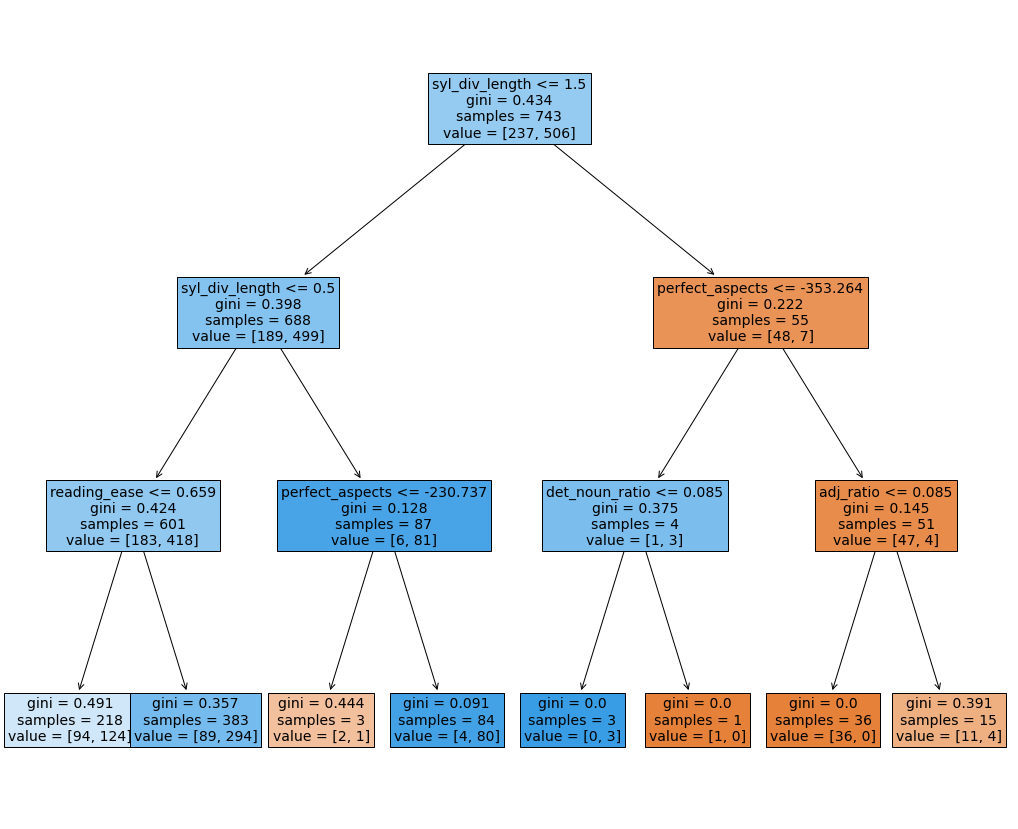

In [50]:
#Tree plot
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

plt.figure(figsize=(18,15))
tree.plot_tree(tree_final, feature_names= new_feature_list,
 filled = True, fontsize=14);

* Since we set depth to 3, there will only be 3 levels in this tree. 
At depth 0, we see that the model uses syl_div_length as the root node. This means 
that the model first asks itself, if syl_div_length is less than or equal to 1.5. Based
on that answer, it will follow the true or false path. The gini number quantifies
the 'purity' of the node. So, a gini score greater than 0 suggests that the samples 
in that node are pure, and within that node, only 1 class of samples exists. The sample's
number indicates that there are a total of 743 samples in this model's dataset. Lastly,
the value indicates how many samples at that node fall into each category.

* Then, this is split into depth 1, which consists of examples that have
syl_div_length <= 0.5, and the other choice as perfect_aspects<= -353. This continues
until we hit the depth of 3. The model chooses different features per depth, and 
continues to provide T/F choices per node. 

* Overall, the model is choosing splits based on the root node, then chooses a feature
to split on. It looks at subsets, and it calculates the purity/impurity at each depth, 
until it reaches the max depth of 3.

### 4.2 Features created, and why

| Feature            | Description                                                                                                                                                                                                                                                                                                      |
|--------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `lex_density`      | - Lexical density of a text<br>- We thought Asian English learners tend to have difficulties using proper articles for nouns or proper prepositions. Therefore, we expected that we would observe higher lexical density in Asian learners' texts over European learners' texts.                                 |
| `adj_ratio`        | - A ratio of adjectives to the number of words: We thought that adjectives were more often used in Asian languages than in European languages.                                                                                                                                                                   |
| `det_noun_ratio`   | - A ratio of combinations of determinant-noun to the number of words<br> - In Eastern Asian languages, there is no concept of articles. Therefore, articles/determinants are easy to be omitted for those English learners.                                                                                           |
| `adj_noun_boolean` | - In French and Spanish, adjectives comes after nouns, but in Eastern Asian languages, nouns comes after adjectives like in English. At first, we were going to check if there were any noun-adj patterns, but it was challenging as pos_tag cannot identify adjectives coming after nouns as adjectives.        |
| `non_alpha_ratio`  | - A ratio of special non alphanumeric characters to the length of a text<br> - In Eastern Asian culture (particularly in a context of webtexts), people often use a lot of non-alphanumeric characters to create text-based emoticons. For example, ^^ represents a smiling face and +_+ represents an excited face.  |
| `syl_div_length`   | - A ratio of syllables in the sentence, divided by the total length of the sentence. This is because in Asian languages, we suspect they may write shorter sentences, and this is one way to tell.                                                                                                               |
| `sent_cmp_bool`    | - A test of completeness in the sentence, which is simply checking if there is more than 1 noun and more than 1 verb in the sentence. This way, if there are any incomplete sentences, which may be more common in Asian English learners, then this would help us differentiate that.                           |
| `sent_cmp_ratio`   | - This checks to see how many nouns/pronouns there are, compared to verbs. This will tell us how many subjects there are, compared to verbs in their sentences. We suspect that Asian English learners would use an equal amount or more verbs in their sentences, since they seemed to talk more about actions. |
| `lemma_txt_match`  | - This checks to see if the sentence is equal to it’s lemmatized form. If it is, there’s a higher chance that the speaker is an Asian English learner, because it’s quite common to forget to add “s” for pluralization or use the base form for words.                                                          |
| `type_token_ratio` | - Checks the number of different types of words in the sentence, dividied by the length of the sentence. The complexity might be lower for Asian English learners, but we’ll have to let the model decide on this one.                                                                                           |
| `art_freq`         | - Frequency of articles in the sentence<br>- Asian languages do not have articles; therefore, it is likely that Asian English speakers do not use articles in their sentences.                                                                                                                                   |
| `perfect_aspects`  | - There is no perfect aspect in Asian languages but there are perfect aspects in European languages. Therefore, we thought that this would be a good feature to distinguish between European and Asian native language speakers.                                                                                 |
| `euro_asia_occ`    | - Occurrence of words associated with European / Asian places, culture and food: We thought that the appearance of places or particular food or cultural events could be used to distinguish European and Asian native language speakers.                                                                        |
| `reading_ease`     | - French and Spanish speakers are likely to follow the same sentence structure as English and substitute words from their native languages with English words.                                                                                                                                                   |

### 4.3 How did the features perform

How did the features perform: 

* Final accuracy score on test_set: ~0.71

* Final feature used(10): 'adj_ratio', 'det_noun_ratio', 'non_alpha_ratio', 'syl_div_length', 'lemma_txt_match', 'type_token_ratio', 'art_freq', 'perfect_aspects', 'euro_asia_occ', 'reading_ease'

* They ended up being around the same score, with the baseline model around 0.71, and our model being 0.71 as well. The features didn’t strongly negatively affect our model, and it was still fitting correctly around 71% of the time. 
* Which means, we ended up dropping: * Which means, we ended up dropping: sent_cmp_bool, lex_density, adj_noun_boolean, and sent_cmp_ratio. 


### 4.4 What each member did

1. Christina: set-up the repository, set-up meetings
    - Part 1: extracted filename, 
    - Part 2: implemented four features and implemented the wrap-up function (which constructs the data set). 
    - Part 5: tried different models with 10 features. 
             
2. Daniel
    - Part 2: brainstorming and note taking during meeting, coded 4 of the possible features
    - Part 3: briefly helped with part 3 design
    - Part 4: completed part 4. 

3. Jin
    - Part 2: brainstorming, checked others' codes, feature extraction (5 features)
    - Part 3: wrapped up the part 3, fixed codes, reported the test score.
    - Organized the whole report.

4. Sheena
    - Part 2: feature extraction(1 feature), tested Part 2 feature functions
    - Part 3: helped with Part 3 implementation. 

## Part 5: Try with other models

In [51]:
dc = DecisionTreeClassifier(max_depth = 3, random_state = 123)
dc.fit(X_train, y_train)
print("Preliminary accuracy score on dev_set: ", accuracy_score(y_valid, dc.predict(X_valid)))

Preliminary accuracy score on dev_set:  0.7357723577235772


In [52]:
rf = RandomForestClassifier(max_depth = 3, random_state = 123)
rf.fit(X_train, y_train)
print("Preliminary accuracy score on dev_set: ", accuracy_score(y_valid, rf.predict(X_valid)))

Preliminary accuracy score on dev_set:  0.7398373983739838


In [53]:
lg = LGBMClassifier(max_depth = 3, random_state = 123, num_leaves = 32)
lg.fit(X_train, y_train)
print("Preliminary accuracy score on dev_set: ", accuracy_score(y_valid, lg.predict(X_valid)))

Preliminary accuracy score on dev_set:  0.7235772357723578


In [54]:
cat = CatBoostClassifier(max_depth = 3, random_state = 123, verbose = 0)
cat.fit(X_train, y_train)
print("Preliminary accuracy score on dev_set: ", accuracy_score(y_valid, cat.predict(X_valid)))

Preliminary accuracy score on dev_set:  0.7317073170731707


In [55]:
X_train, X_valid, new_feature_list = backward_selection(rf, feature_dicts_t, y_train, feature_dicts_v, y_valid, 10)
print(f"Remaining features: {new_feature_list}")

The original number of features:  14


#######################The number of features: 13#######################


Current accuracy with one feature removed: {'lex_density': 0.736, 'adj_ratio': 0.736, 'det_noun_ratio': 0.736, 'adj_noun_boolean': 0.736, 'non_alpha_ratio': 0.703, 'syl_div_length': 0.728, 'sent_cmp_bool': 0.74, 'sent_cmp_ratio': 0.736, 'lemma_txt_match': 0.732, 'type_token_ratio': 0.728, 'art_freq': 0.736, 'perfect_aspects': 0.732, 'euro_asia_occ': 0.736, 'reading_ease': 0.74}
Feature will be removed: ('sent_cmp_bool', 0.74)
Current best accuracy: 0.74


#######################The number of features: 12#######################


Current accuracy with one feature removed: {'lex_density': 0.74, 'adj_ratio': 0.74, 'det_noun_ratio': 0.736, 'adj_noun_boolean': 0.74, 'non_alpha_ratio': 0.695, 'syl_div_length': 0.74, 'sent_cmp_ratio': 0.732, 'lemma_txt_match': 0.74, 'type_token_ratio': 0.736, 'art_freq': 0.74, 'perfect_aspects': 0.736, 'euro_asia_occ': 0.736, 'reading_ease': 0.74}

In [56]:
X_train, X_valid, new_feature_list = backward_selection(lg, feature_dicts_t, y_train, feature_dicts_v, y_valid,10)
print(f"Remaining features: {new_feature_list}")

The original number of features:  14


#######################The number of features: 13#######################


Current accuracy with one feature removed: {'lex_density': 0.76, 'adj_ratio': 0.76, 'det_noun_ratio': 0.752, 'adj_noun_boolean': 0.764, 'non_alpha_ratio': 0.72, 'syl_div_length': 0.76, 'sent_cmp_bool': 0.732, 'sent_cmp_ratio': 0.752, 'lemma_txt_match': 0.772, 'type_token_ratio': 0.756, 'art_freq': 0.76, 'perfect_aspects': 0.74, 'euro_asia_occ': 0.76, 'reading_ease': 0.748}
Feature will be removed: ('lemma_txt_match', 0.772)
Current best accuracy: 0.772


#######################The number of features: 12#######################


Current accuracy with one feature removed: {'lex_density': 0.772, 'adj_ratio': 0.748, 'det_noun_ratio': 0.744, 'adj_noun_boolean': 0.76, 'non_alpha_ratio': 0.695, 'syl_div_length': 0.772, 'sent_cmp_bool': 0.736, 'sent_cmp_ratio': 0.76, 'type_token_ratio': 0.768, 'art_freq': 0.772, 'perfect_aspects': 0.756, 'euro_asia_occ': 0.76, 'reading_ease': 0.776

In [57]:
X_train, X_valid, new_feature_list = backward_selection(cat, feature_dicts_t, y_train, feature_dicts_v, y_valid,10)
print(f"Remaining features: {new_feature_list}")

The original number of features:  14


#######################The number of features: 13#######################


Current accuracy with one feature removed: {'lex_density': 0.744, 'adj_ratio': 0.736, 'det_noun_ratio': 0.748, 'adj_noun_boolean': 0.748, 'non_alpha_ratio': 0.715, 'syl_div_length': 0.74, 'sent_cmp_bool': 0.732, 'sent_cmp_ratio': 0.752, 'lemma_txt_match': 0.744, 'type_token_ratio': 0.74, 'art_freq': 0.744, 'perfect_aspects': 0.756, 'euro_asia_occ': 0.756, 'reading_ease': 0.74}
Feature will be removed: ('perfect_aspects', 0.756)
Current best accuracy: 0.756


#######################The number of features: 12#######################


Current accuracy with one feature removed: {'lex_density': 0.748, 'adj_ratio': 0.732, 'det_noun_ratio': 0.74, 'adj_noun_boolean': 0.748, 'non_alpha_ratio': 0.728, 'syl_div_length': 0.756, 'sent_cmp_bool': 0.74, 'sent_cmp_ratio': 0.748, 'lemma_txt_match': 0.748, 'type_token_ratio': 0.752, 'art_freq': 0.748, 'euro_asia_occ': 0.76, 'reading_ease': 0

We observe that the Random Forest classifier returns the validation score of 0.74, lightGBM 0.78 and Catboost 0.77.

In [58]:
# get final dataframe for test, training

feature_dicts_test, filename_list_test, y_test = construct_test_datasets(test_txt, READ_FROM_ZIP, RANDOM_FOREST)

# vectorize
X_train_final, X_test = vectorize(feature_dicts_t_final, feature_dicts_test)

# model
rf_final = RandomForestClassifier(max_depth=3, verbose = 0, random_state = 123)

# fit
rf_final.fit(X_train_final, y_train_final)

# report the test score
print("Final accuracy score on test_set: ", round(accuracy_score(y_test, rf_final.predict(X_test)), 2))
print(f"Final feature used: {new_feature_list}")

Final accuracy score on test_set:  0.71
Final feature used: ['lex_density', 'adj_ratio', 'det_noun_ratio', 'adj_noun_boolean', 'non_alpha_ratio', 'syl_div_length', 'sent_cmp_bool', 'sent_cmp_ratio', 'type_token_ratio', 'reading_ease']


In [59]:
# get final dataframe for test, training

feature_dicts_test, filename_list_test, y_test = construct_test_datasets(test_txt, READ_FROM_ZIP, LGBM)

# vectorize
X_train_final, X_test = vectorize(feature_dicts_t_final, feature_dicts_test)

# model
lg_final = LGBMClassifier(max_depth=3, verbose = 0, random_state = 123, num_leaves = 32)

# fit
lg_final.fit(X_train_final, y_train_final)

# report the test score
print("Final accuracy score on test_set: ", round(accuracy_score(y_test, lg_final.predict(X_test)), 2))
print(f"Final feature used: {new_feature_list}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [60]:
# get final dataframe for test, training

feature_dicts_test, filename_list_test, y_test = construct_test_datasets(test_txt, READ_FROM_ZIP, CATBOOST)

# vectorize
X_train_final, X_test = vectorize(feature_dicts_t_final, feature_dicts_test)

# model
cat_final = CatBoostClassifier(max_depth=3, verbose = 0, random_state = 123)

# fit
cat_final.fit(X_train_final, y_train_final)

# report the test score
print("Final accuracy score on test_set: ", round(accuracy_score(y_test, cat_final.predict(X_test)), 2))
print(f"Final feature used: {new_feature_list}")

Final accuracy score on test_set:  0.69
Final feature used: ['lex_density', 'adj_ratio', 'det_noun_ratio', 'adj_noun_boolean', 'non_alpha_ratio', 'syl_div_length', 'sent_cmp_bool', 'sent_cmp_ratio', 'type_token_ratio', 'reading_ease']


## Final Score 

| Model | Test Score | 
|-------|------------|
| Decision Tree | 0.71 |
| Random Forest | 0.71 |
| Light GBM | 0.7 |
| Catboost | 0.69 | 